In [3]:
import os
import sys

PROJECT_PATH = os.path.abspath(os.path.join(os.path.dirname("__file__"), ".."))
sys.path.append(PROJECT_PATH)
from models.classifiers.deepHits_4class_nans_norm_stamp_model import (
    DeepHiTS4ClassModelNanNormStamp,
)
from modules.occlusion_generator import OcclusionGenerator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from parameters import general_keys, param_keys

In [4]:
# data_path = os.path.join("../../pickles", 'training_set_with_bogus.pkl')
data_path = "../../pickles/converted_data.pkl"
checkpoint_path = os.path.join(
    PROJECT_PATH, "results/best_model_so_far/checkpoints", "model"
)

params = {
    param_keys.DATA_PATH_TRAIN: data_path,
    param_keys.NUMBER_OF_CLASSES: 5,
    param_keys.KERNEL_SIZE: 3,
    param_keys.BATCHNORM_FC: None,
    param_keys.BATCHNORM_CONV: None,
    param_keys.DROP_RATE: 0.5,
    param_keys.BATCH_SIZE: 50,
    param_keys.N_INPUT_CHANNELS: 3,
    param_keys.CHANNELS_TO_USE: [0, 1, 2],
    param_keys.NANS_TO: 0,
}

model = DeepHiTS4ClassModelNanNormStamp(params)
model.load_model(checkpoint_path)
train_set, val_set, test_set = model._data_init()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /home/ereyes/Projects/Alerce/stamp_classifier/results/best_model_so_far/checkpoints/model
499 misshaped samples removed. 
3568 samples with NaNs. NaNs replaced with number 0


In [5]:
# this function takes a list of heatmaps and merges them into one single heatmap
def post_process(heatmap):
    # postprocessing
    total = heatmap[0]
    for val in heatmap[1:]:
        total = total + val
    total = total / np.max(total)
    return total

In [6]:
#### This is the meat of the program. It generates the heatmap for the given image location ####


def gen_heatmap(
    sample, model: DeepHiTS4ClassModelNanNormStamp, box, step, verbose=False
):
    sample_size = sample.shape[0]
    pad_size = box.shape[0] - 1

    preds = model.predict_proba(sample[np.newaxis, ...])  # [np.newaxis, ...])
    pred_class_index = np.argmax(preds[0])
    # print(pred_class_index)
    # print(preds)
    pred_class_proba = preds[0][pred_class_index]

    # load correct label text
    ztf_labels = ["AGN", "SN", "VS", "asteroid", "bogus"]
    pred_class_name = ztf_labels[pred_class_index]

    # generate occluded images and location of mask

    occluder = OcclusionGenerator(sample, box, step)
    occluded_sample, occlusion_locations = occluder.gen_minibatch()
    occluded_predictions = model.predict_proba(occluded_sample)

    if verbose:
        print("processng %i images" % occluded_predictions.shape[0])
    heatmap = []
    # unpack prediction values
    for occluded_sample_idx in range(occluded_sample.shape[0]):
        score = occluded_predictions[occluded_sample_idx][pred_class_index]
        r, c = occlusion_locations[occluded_sample_idx]
        scoremap = np.zeros(
            (sample.shape[0] + pad_size * 2, sample.shape[1] + pad_size * 2)
        )
        # print(r,c,occluder.box_size)
        scoremap[r : r + occluder.box_size, c : c + occluder.box_size] = score
        # print(scoremap.shape)
        scoremap = scoremap[
            pad_size : pad_size + sample_size, pad_size : pad_size + sample_size
        ]
        heatmap.append(scoremap)

    return heatmap, pred_class_name, pred_class_proba

In [7]:
# run the program on sample i
sample_i = np.random.randint(train_set.data_array.shape[0])
sample = train_set.data_array[sample_i]
box_size = 3
box_step = 1
box = np.ones([box_size, box_size, sample.shape[-1]]) * np.median(sample, axis=[0, 1])

heatmapList, pred_name, pred_proba = gen_heatmap(sample, model, box, box_step)
processed_hm = post_process(heatmapList)

In [8]:
print("max ", processed_hm.max())
print("0,0 ", processed_hm[0, 0])
print("min ", processed_hm.min())
print("31,31 ", processed_hm[31, 31])

max  1.0
0,0  0.9762539248736103
min  0.2569099293071976
31,31  0.2569099293071976


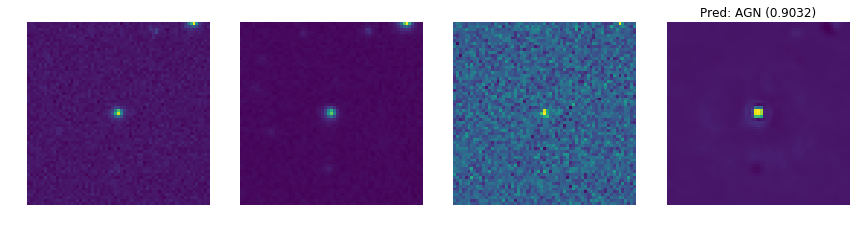

In [13]:
from IPython.display import display

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 12)


def plot_hm(sample, box, sample_i=None):
    heatmapList, pred_name, pred_proba = gen_heatmap(sample, model, box, box_step)
    processed_hm = post_process(heatmapList)
    plt.set_cmap("viridis")
    for i in range(3):
        plt.subplot(1, 4, i + 1)
        plt.imshow(sample[..., i])
        plt.axis("off")
        if i == 0 and sample_i != None:
            plt.title("Sample %i" % sample_i)
    plt.subplot(1, 4, 4)
    plt.imshow(processed_hm)
    plt.set_cmap("viridis_r")
    plt.axis("off")
    plt.title("Pred: %s (%.4f)" % (pred_name, pred_proba))
    plt.tight_layout()
    plt.show()


plot_hm(sample, box)

In [17]:
box_size = 3
box_step = 1
box = np.ones([box_size, box_size, sample.shape[-1]]) * np.median(sample, axis=[0, 1])

n_samples_to_plot = 20
for sample_i in range(n_samples_to_plot):
    sample = train_set.data_array[sample_i]
    # plot_hm(sample, box, sample_i)